# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

2022-05-05 16:47:36.017141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (256, 256, 256), (256, 256, 256)
num_epoch = 500
batch_size = 1000

# Load and Process Data

In [3]:
signal_1_df = "/global/home/users/yifengh3/VAE/new_data/muon_data/h_signal_big_muons.h5"
signal_2_df = "/global/home/users/yifengh3/VAE/new_data/muon_data/hv_signal_big_muons.h5"
raw_signal_1 = pandas.read_hdf(signal_1_df)
raw_signal_2 = pandas.read_hdf(signal_2_df)

In [4]:
print("signal_1 data shape: {}".format(raw_signal_1.shape))
print("signal_2 data shape: {}".format(raw_signal_2.shape))

signal_1 data shape: (173692, 8)
signal_2 data shape: (157772, 8)


In [5]:
raw_signal_1

,pT0,eta0,phi0,E0,pT1,eta1,phi1,E1
0,13.0,62.4740,-1.701850,62.4740,-13.0,40.94240,-1.718690,40.94240
1,13.0,13.4565,-0.243036,13.4565,-13.0,33.92570,-0.287077,33.92570
2,13.0,66.1971,-0.342065,66.1971,-13.0,4.71550,-0.290955,4.71550
3,13.0,50.8922,-1.790440,50.8922,-13.0,12.91650,-1.806460,12.91650
4,13.0,59.7630,-1.344120,59.7630,-13.0,16.97240,-1.327890,16.97240
...,...,...,...,...,...,...,...,...
6881,13.0,31.9867,-2.338530,31.9867,-13.0,20.39380,-2.300500,20.39380
6882,13.0,47.7360,-2.012180,47.7360,-13.0,8.02589,-1.974860,8.02589
6883,13.0,51.4818,0.027498,51.4818,-13.0,59.43760,0.043301,59.43760
6884,13.0,22.5427,1.615810,22.5427,-13.0,36.42490,1.648680,36.42490


In [6]:
#Truncate the nan
signal_1 = raw_signal_1.to_numpy()[:,:8]
signal_2 = raw_signal_2.to_numpy()[:,:8]

In [7]:
np.mean(signal_1,axis=0)

array([ 1.30000000e+01,  3.27471798e+01,  1.18269860e-03,  3.27471798e+01,
       -1.30000000e+01,  3.27521130e+01,  1.05764062e-03,  3.27521130e+01])

In [8]:
print("signal_1 data shape: {}".format(signal_1.shape))
print("signal_2 data shape: {}".format(signal_2.shape))

signal_1 data shape: (173692, 8)
signal_2 data shape: (157772, 8)


In [9]:
# assign labels to signal and background data, 0 for sig1,  1 for sig2
# (updated since we might get multiple signals) 
labeled_sig1 = np.append(signal_1,np.zeros((signal_1.shape[0],1)),axis=1)
labeled_sig2 = np.append(signal_2,np.ones((signal_2.shape[0],1)),axis=1)

In [10]:
# mix two data array into one signal array
data = np.concatenate((labeled_sig1,labeled_sig2))

#and shuffle the data
np.random.shuffle(data)

In [11]:
X = data[:,:-1]
y = data[:,-1]

In [12]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (331464, 8)
shape of Y: (331464,)


In [13]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = labeled_sig1.shape[0] + labeled_sig2.shape[0]
weight_for_0 = (1 / labeled_sig1.shape[0]) * (total / 2.0)
weight_for_1 = (1 / labeled_sig2.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.95
Weight for signal: 1.05


In [14]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 4)
X = X.reshape(-1,2,4)

# ignore the pid info
X = X[:,:,:3]

In [15]:
print(X.shape)

(331464, 2, 3)


In [16]:
# # normalizing jets
# # copied from example
# import tqdm
# for x in tqdm.tqdm(X):
#     # now add the status bar :)
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()

In [17]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (331464, 2, 3)
shape of Y: (331464,)


In [18]:
X = X.astype('float64')

In [19]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [20]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:


2022-05-05 16:47:38.935564: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-05 16:47:38.936406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-05 16:47:38.966645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-05-05 16:47:38.966666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-05 16:47:38.968007: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-05 16:47:38.968036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1024        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation[0][0]                 
______________________________________________________________________________________________

In [21]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/5), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/500


2022-05-05 16:47:39.849951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-05 16:47:39.850402: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz


  1/199 [..............................] - ETA: 1:51 - loss: 27.0440 - acc: 0.5030

2022-05-05 16:47:40.255408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


199/199 [==============================] - 2s 5ms/step - loss: 4.7067 - acc: 0.8105 - val_loss: 0.3495 - val_acc: 0.8662
Epoch 2/500
199/199 [==============================] - 1s 3ms/step - loss: 0.2929 - acc: 0.8904 - val_loss: 0.3012 - val_acc: 0.8891
Epoch 3/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2871 - acc: 0.8925 - val_loss: 0.2843 - val_acc: 0.8932
Epoch 4/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2848 - acc: 0.8934 - val_loss: 0.3010 - val_acc: 0.8843
Epoch 5/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2851 - acc: 0.8930 - val_loss: 0.2859 - val_acc: 0.8930
Epoch 6/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2840 - acc: 0.8926 - val_loss: 0.2842 - val_acc: 0.8932
Epoch 7/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2880 - acc: 0.8910 - val_loss: 0.2822 - val_acc: 0.8931
Epoch 8/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2834

199/199 [==============================] - 1s 4ms/step - loss: 0.2612 - acc: 0.9004 - val_loss: 0.2512 - val_acc: 0.9043
Epoch 62/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2567 - acc: 0.9015 - val_loss: 0.2628 - val_acc: 0.8992
Epoch 63/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2652 - acc: 0.8985 - val_loss: 0.2595 - val_acc: 0.9010
Epoch 64/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2520 - acc: 0.9038 - val_loss: 0.2608 - val_acc: 0.9005
Epoch 65/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2540 - acc: 0.9033 - val_loss: 0.2465 - val_acc: 0.9068
Epoch 66/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2478 - acc: 0.9053 - val_loss: 0.2516 - val_acc: 0.9035
Epoch 67/500
199/199 [==============================] - 1s 4ms/step - loss: 0.2476 - acc: 0.9055 - val_loss: 0.2511 - val_acc: 0.9043
Epoch 68/500
199/199 [==============================] - 1s 4ms/step - loss:

Epoch 177/500
199/199 [==============================] - 1s 4ms/step - loss: 0.1989 - acc: 0.9248 - val_loss: 0.2099 - val_acc: 0.9215
Epoch 178/500
199/199 [==============================] - 1s 4ms/step - loss: 0.1994 - acc: 0.9244 - val_loss: 0.2097 - val_acc: 0.9213
Epoch 179/500
199/199 [==============================] - 1s 4ms/step - loss: 0.1956 - acc: 0.9256 - val_loss: 0.2097 - val_acc: 0.9212
Epoch 180/500
199/199 [==============================] - 1s 4ms/step - loss: 0.1990 - acc: 0.9243 - val_loss: 0.2098 - val_acc: 0.9210
Epoch 181/500
199/199 [==============================] - 1s 4ms/step - loss: 0.1996 - acc: 0.9239 - val_loss: 0.2101 - val_acc: 0.9209
Epoch 00181: early stopping


# Analyze the Model

In [22]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.9722873486785715



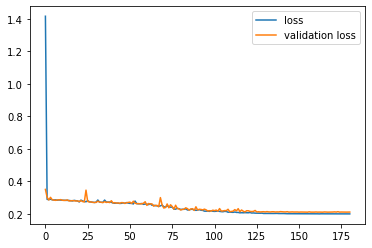

In [23]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

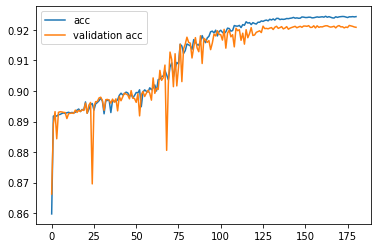

In [24]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()

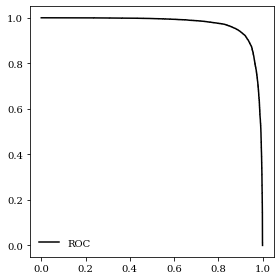

In [25]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='ROC')

plt.legend(loc='lower left', frameon=False)

plt.show()

/tmp/ipykernel_6191/1246046417.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')


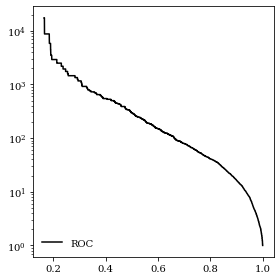

In [26]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')

plt.yscale('log')

plt.legend(loc='lower left', frameon=False)

plt.show()

In [28]:
pfn_tp

array([0.        , 0.06565303, 0.08442013, ..., 0.99993638, 1.        ,
       1.        ])

In [27]:
pfn.save_weights("weights/muon_only/weight2")